In [19]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import rasterio as ras

**Read in TIF data and convert to numpy**

In [20]:
# Read TIF file using rasterio then converting to numpy array
data_north = ras.open('./data/raw/20130824_RE3_3A_Analytic_Champaign_north.tif')
data_north = np.array(data_north.read())
cdl = ras.open('./data/raw/CDL_2013_Champaign_north.tif')
cdl = np.array(cdl.read())

# Relabeling: 0 - other, corn - 1, soybean - 2
cdl = np.where((cdl != 1) & (cdl != 5), 0, cdl) # 0 - neither
cdl = np.where((cdl == 5), 2, cdl) # 2 - soybean, 1 = corn
fused = np.concatenate([data_north, cdl])

# Save files
np.save('./data/raw/north_data.npy', data_north)
np.save('./data/raw/north_class.npy', cdl)

**Visualize Data**

North data

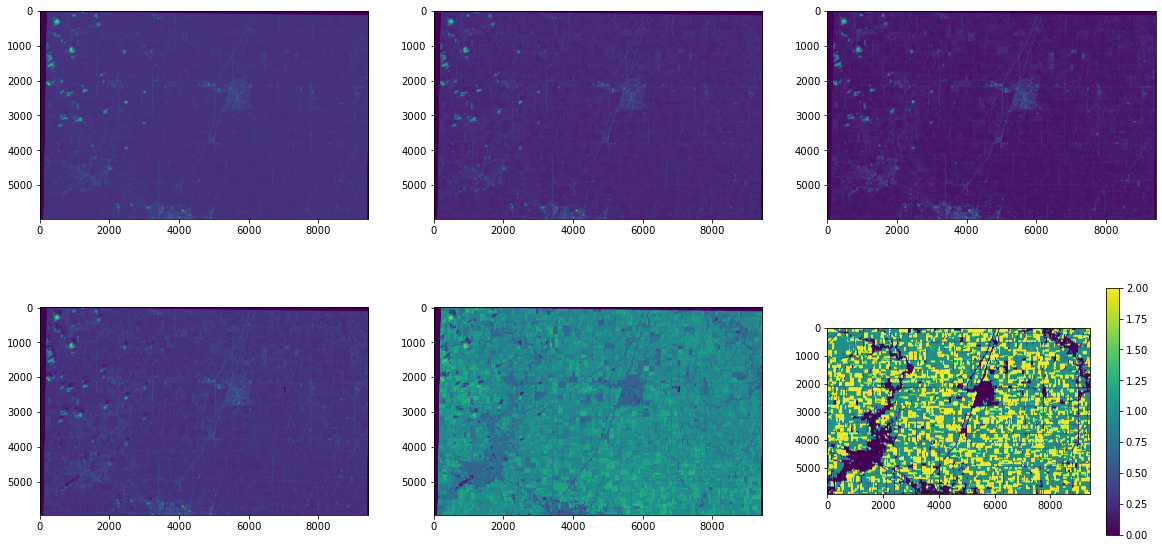

In [24]:
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

for band in range(6):
    ax[band//3][band%3].imshow(fused[band])
gt = ax[1][2].imshow(fused[5])
fig.colorbar(gt, ax=ax[1][2])

South data

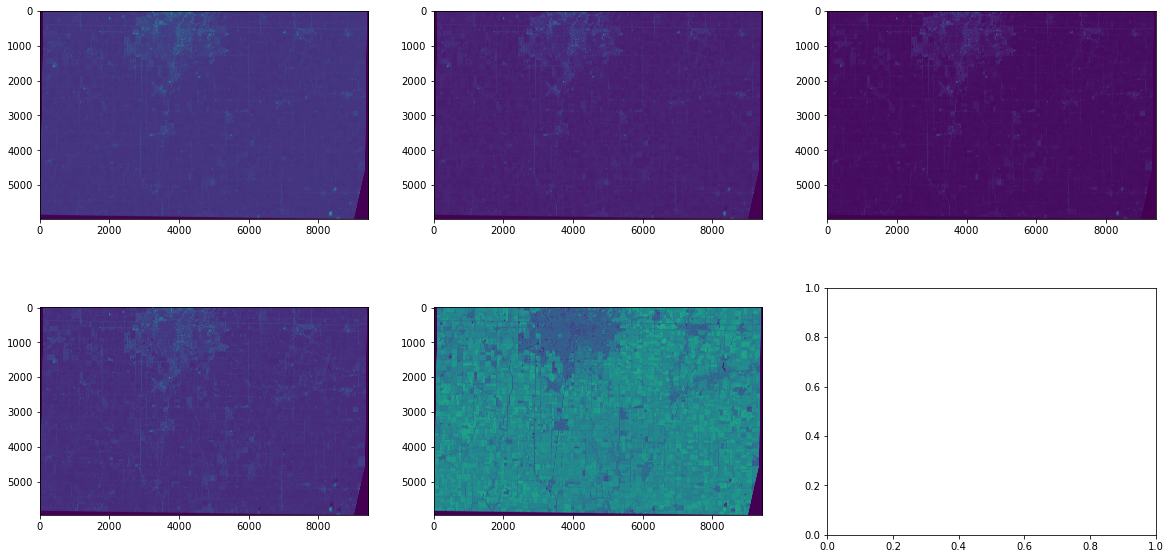

In [27]:
south = np.array(ras.open('./data/raw/20130824_RE3_3A_Analytic_Champaign_south.tif').read())
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

for band in range(5):
    ax[band//3][band%3].imshow(south[band])


**Fuse data, retile, create data sets**

In [28]:
# Retrieve extracted data
data = np.load('./data/raw/north_data.npy')
classes = np.load('./data/raw/north_class.npy')

In [30]:
fused = np.concatenate([data, classes])

In [32]:
tiles = np.array(divide_image(fused, (128, 128), (128, 128)))
np.random.shuffle(tiles)

In [32]:
# Train test split (0.5, 0.25, 0.25)
train_idx = int(0.5 * len(tiles))
size_val = (len(tiles) - train_idx)//2

train_data = tiles[0:train_idx]

valid_data = tiles[train_idx:train_idx+size_val]

test_data = tiles[train_idx+size_val::]

print(len(train_data), len(test_data))

1679 840


In [33]:
data = {
    'train': train_data.transpose(1, 0, 2, 3),
    'valid': valid_data.transpose(1, 0, 2, 3),
    'test': test_data.transpose(1, 0, 2, 3)
}

for subset, value in data.items():
    with h5py.File(subset + '.hdf5', 'w') as f:
        length = value.shape[1]
        print(length)
        print(value.shape)
        imgs = f.create_dataset('samples', (length, 5, 64, 64), data=value[0:5].transpose(1, 0, 2, 3))
        labels = f.create_dataset('labels',(length, 1, 64, 64), data=value[5])


1679
(6, 1679, 128, 128)
839
(6, 839, 128, 128)
840
(6, 840, 128, 128)


**Test Dataset**

In [1]:
import matplotlib.pyplot as plt
import torch
import numpy as np

from torchvision.transforms import v2
from dataset import *


In [8]:
transform =  v2.RandomHorizontalFlip(p=1)
tran = CropDataset(data_path='./data/cropset128/test.hdf5', transform=transform)
norm = CropDataset(data_path='./data/cropset128/test.hdf5', transform=None)


In [21]:
idx = np.random.randint(len(tran))
st, lt = tran[idx]
sn, ln = norm[idx]
sa = torch.cat((st, lt))
na = torch.cat((sn, ln))